In [1]:
!pip install praw

     |████████████████████████████████| 143kB 4.8MB/s 
     |████████████████████████████████| 204kB 18.3MB/s 


In [0]:
import praw
from prawcore.exceptions import Forbidden
import pandas as pd
import pprint

In [22]:
reddit = praw.Reddit(client_id='a-AkmIGG_wTu9g', client_secret='g-UH-9tys1eOCbXCBQlWpessBMI', user_agent='crypto_lovers')
print(reddit.user.me())

None


In [24]:
hot_posts = reddit.subreddit('Ripple').hot(limit=10)
for post in hot_posts:
    print(post.title)

Ripple Subreddit Rules, Helpful Links & Answers to Common Questions - READ BEFORE POSTING
Daily Ripple/XRP Discussion Thread 03/22/20 [Join Our Discord] invite link: discord.gg/7Bv2rYf
Daily Ripple/XRP Discussion Thread 03/21/20 [Join Our Discord] invite link: discord.gg/7Bv2rYf
How might the global economy crashing due to COVID-19, relate to Ripple and ODL?
Randi Zuckerberg, yeah his sister, believes Ripple is the next Amazon. She's a big believer in block chain and believes that Ripple and Asia will lead the way. Seems like she is a Silicon Valley power broker, look into what she's said and her interview with Asheesh Birlah.
Daily Ripple/XRP Discussion Thread 03/20/20 [Join Our Discord] invite link: discord.gg/7Bv2rYf
DeeMoney Partners with Ripple to Power Faster and Cheaper Cross-Border Money Transfers | Ripple
Ripple partners with Thailand's DeeMoney to process faster cross-border payments
Daily Ripple/XRP Discussion Thread 03/19/20 [Join Our Discord] invite link: discord.gg/7Bv2rY

In [134]:
posts = []
ripple_subreddit = reddit.subreddit('Ripple')
for post in ripple_subreddit.hot(limit=2):
    posts.append([post.title, post.score, post.id, post.subreddit, post.url, post.num_comments, post.selftext, post.created])
posts = pd.DataFrame(posts,columns=['title', 'score', 'id', 'subreddit', 'url', 'num_comments', 'body', 'created'])
posts

,title,score,id,subreddit,url,num_comments,body,created
0,"Ripple Subreddit Rules, Helpful Links & Answer...",624,7l94ng,Ripple,https://www.reddit.com/r/Ripple/comments/7l94n...,346,You must read our [rules](https://www.reddit.c...,1.513888e+09
1,Daily Ripple/XRP Discussion Thread 03/22/20 [J...,3,fmtmmd,Ripple,https://www.reddit.com/r/Ripple/comments/fmtmm...,0,Hello! It's Sunday. Welcome to our daily discu...,1.584879e+09


In [38]:
s = reddit.subreddit('Ripple').subscribers
s

210931

In [72]:
from google.colab import drive
drive.mount('/content/gdrive')
# %cd gdrive/My Drive/INFO_290
%cd Reddit

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/INFO_290/Reddit


In [68]:
import urllib           # navigate to web page, get html data
from json import loads  # deserialise the html data for cleaning / parsing
import pandas as pd     # analysing and aggregating the data
from time import sleep  # add a pause to the scraping
import sys              # parsing cmd-line args, and exiting script cleanly

#-------------------------------------------------------------------------------------
# IMPORT MODULES
#-------------------------------------------------------------------------------------
class ScrapeRedditMetrics():
    def __init__(self, url):
        self.url = url  
        
    def get_script_text(self):        
        """ 
        Open the web page. Print warning (and continue) if page doesn't open. 
        Return the html from the page, or None if the page doesn't open.
        """
        html = None
        try: 
            page = urllib.request.urlopen(self.url).read()
            html = page.decode("utf8")
        except:
            print("*** WARNING: URL " + self.url + " did not open successfully. ***")
    
        return html

    def retrieve_data(self, html):
        """
        Find the part of the html with the total number of subscribers over time. 
        
        Parameters:
            - html, a single string containing all the html in the page.
        Return a string containing all the subscriber data, or None if 
            'total-subscribers' can't be found in the html for any reason
        """
        search_string = "element: 'total-subscribers',"
        
        # In the html, the subscriber info is an array of Javascript objects (or a list 
        # of python dicts), but extracted here as a single long string.
        start_segment = html.find(search_string)
        # make sure the search string exists
        if start_segment != -1:
            start_list = html.find("[", start_segment)
            end_list = html.find("]", start_list)
            return html[start_list:end_list + 1]
        else:
            return None

    def convert_text_to_dataframe(self, data_list):
        """
        Convert the string of subscriber data to a pandas dataframe (via JSON).         
        
        Parameters:
            - data_list, a string containing the total-subscribers JSON        
        Returns a pandas dataframe containing subscriber counts per day (as 
        a date object)
        """
        # clean up the fields
        data_list = data_list.replace("'", '"')
        data_list = data_list.replace('a', '\"subscriber_count\"')
        data_list = data_list.replace('y', '\"date\"')
        
        # convert the string to a list of python dicts
        try:
            subscriber_data = loads(data_list)
        except ValueError:
            print("*** WARNING: No data retrieved for "+self.url+" ***")
            return None
        
        # convert to dataframe and parse dates from string to 'date'
        df = pd.DataFrame(subscriber_data)
        df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d")
        
        return df
    
    # def aggregate_output(self, subscriber_counts):
    #     """
    #     Take the daily subscriber values for the last day of each month, for the 12
    #     months of 2016 *only*, and average for these 12 values.
        
    #     NOTE: *a lot* of data is thrown away here! What's left is all I need; but 
    #     others may wish to alter this.
        
    #     Parameters:
    #         - subscriber_counts, a dataframe of subscriber counts per day 
    #     Returns a the mean subscriber value for 2016 (i.e. averaged over each month).
    #     """
    #     # get the last day of every month in the df
    #     mth_end_dates = subscriber_counts[subscriber_counts['date'].dt.is_month_end]
    #     # filter to only include the 12 dates from 2016
    #     mth_end_2016 = mth_end_dates[mth_end_dates['date'].dt.year == 2016]
    #     # return the average over these 12 months, i.e. a single value
    #     return mth_end_2016['subscriber_count'].mean()

    def scrape_and_parse(self):
        """
        Run all the methods above, to get the data, parse it an return the averaged 
        results. Return a dataframe with the averaged results if successful, or None 
        if unsuccessful.
        """
        # get the html
        text = self.get_script_text()
        # find the part that corresponds to total subscribers to the subreddit
        if text is not None:
            data_list = self.retrieve_data(text)
            # convert to a pandas dataframe
            if data_list is not None:
                # get monthly subscriber vals for 2016
                df = self.convert_text_to_dataframe(data_list)
                return df
        return None

def get_subreddits(f_in):
    """
    Get a list of subreddits from an existing csv file.
    [NOTE: This is part of my wider workflow, where the data is held in .CSVs]
    
    Parameters:
        - f_in, a csv file containing data on subreddits (incl names of subreddits)
    Returns a list of subreddits (as strings)
    """
    try:
        # df = pd.read_csv(f_in)
        df= f_in
        return df
    except FileNotFoundError:
        #print("File " + f_in + " not found.")
        sys.exit(1)

def usage():
    print("Usage: python ExtractRedditMetricsData.py <input file> <output file>")
    sys.exit()

def main():
    """
    Main driver. Some general setup, including checks for how the script is being 
    run (see "Description" above).
    """
    # set the delay between requests to redditmetrics.com
    wait_time = 2
    
    # decide whether we're getting input and output filenames from the command line,
    # or whether they're hard-coded.
    # if len(sys.argv) == 3:
    #     print("Using cmd-line filepaths")
    #     f_in = sys.argv[1]
    #     f_out = sys.argv[2]
    # elif len(sys.argv) == 1:
    #     # setup file paths
    #     print("Using hard-coded filepaths")
    #     path = "../Data/Input/Processed/"
    #     f_in = path + "PostType.txt"
    #     f_out = path + "SubscriberCounts.txt"
    # else:
    #     usage()
    f_in = ['Ripple', 'XRP', 'Bitcoin', 'Ethereum', 'CryptoCurrency', 'CoinBase', 'Binance']
    # get list of subreddits
    subreddits = get_subreddits(f_in)
    #reddit_data = pd.DataFrame(columns=f_in)
    # some subreddits for testing
#    subreddits = ["thedonald","AskReddit", "announcements"]    
    
    # set up the output file
    # with open(f_out, 'w') as f:
    #     f.write("subreddit,mean_subscribers\n")
    reddit_data = []
    # work through the list of subreddits, scraping the data for each one
    i = 0
    for subreddit in subreddits:
        url = "http://redditmetrics.com/r/"+subreddit 
        srm = ScrapeRedditMetrics(url)
        mean_subscribers = srm.scrape_and_parse()
        if mean_subscribers is not None:
            # write the result to the output file 
            # NOTE: I've found it's better to write after each subreddit is 
            # scraped (rather then wait until the list is processed), to avoid 
            # losing all data if an error is encountered.
            # with open(f_out, 'a') as f:
            #     f.write(str(subreddit)+","+str(mean_subscribers)+"\n")
            mean_subscribers.to_csv(str(subreddit)+'.csv')    
            print("Subreddit " + subreddit + " data retrieved successfully")
        
        # Pause before next request, to avoid DoS'ing the website
        #reddit_data[i] = mean_subscribers
        sleep(wait_time)
        i = i+1
    return subreddits, mean_subscribers   
if __name__ == '__main__':
    subreddits, mean_subscribers = main()

Subreddit Ripple data retrieved successfully
Subreddit XRP data retrieved successfully
Subreddit Bitcoin data retrieved successfully
Subreddit Ethereum data retrieved successfully
Subreddit CryptoCurrency data retrieved successfully
Subreddit CoinBase data retrieved successfully
Subreddit Binance data retrieved successfully


In [73]:
subreddits

['Ripple',
 'XRP',
 'Bitcoin',
 'Ethereum',
 'CryptoCurrency',
 'CoinBase',
 'Binance']

In [0]:
Ripple = pd.read_csv('Ripple.csv')
XRP = pd.read_csv('XRP.csv')
Bitcoin = pd.read_csv('Bitcoin.csv')
Ethereum = pd.read_csv('Ethereum.csv')
CryptoCurrency = pd.read_csv('CryptoCurrency.csv')
CoinBase = pd.read_csv('CoinBase.csv')
Binance = pd.read_csv('Binance.csv')

In [77]:
Ripple

,Unnamed: 0,date,subscriber_count
0,0,2012-10-29,1
1,1,2012-10-30,1
2,2,2012-10-31,1
3,3,2012-11-01,1
4,4,2012-11-02,1
...,...,...,...
2701,2701,2020-03-16,210796
2702,2702,2020-03-17,210831
2703,2703,2020-03-18,210854
2704,2704,2020-03-19,210884


In [120]:
df = (pd.merge(Bitcoin, Binance, on = "date", how='left')
        .fillna(0)
        # .rename(columns={'subscriber_count':'Ripple','subscriber_count':'XRP'})
        # .assign(total=lambda x: x['Ripple'] + x['XRP'])
      )

df = (pd.merge(df, Ripple, on = "date", how='left')
        .fillna(0)
      )
df = (pd.merge(df, XRP, on = "date", how='left')
        .fillna(0)
      )
df = (pd.merge(df, Ethereum, on = "date", how='left')
        .fillna(0)
      )
df = (pd.merge(df, CoinBase, on = "date", how='left')
        .fillna(0)
      )
df = (pd.merge(df, CryptoCurrency, on = "date", how='left')
        .fillna(0)
      )
df= df.drop(['Unnamed: 0_x'], axis=1)
df= df.drop(['Unnamed: 0_y'], axis=1)
df= df.drop(['Unnamed: 0'], axis=1)
df

,date,subscriber_count_x,subscriber_count_y,subscriber_count_x,subscriber_count_y,subscriber_count_x,subscriber_count_y,subscriber_count
0,2012-10-29,11274,0.0,1,0.0,0.0,0.0,0.0
1,2012-10-30,11292,0.0,1,0.0,0.0,0.0,0.0
2,2012-10-31,11301,0.0,1,0.0,0.0,0.0,0.0
3,2012-11-01,11329,0.0,1,0.0,0.0,0.0,0.0
4,2012-11-02,11343,0.0,1,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2949,2020-03-16,1322415,60216.0,210796,41952.0,454924.0,46725.0,983043.0
2950,2020-03-17,1324098,60259.0,210831,41990.0,455014.0,46759.0,983575.0
2951,2020-03-18,1325705,60294.0,210854,42011.0,455082.0,46775.0,984028.0
2952,2020-03-19,1327126,60313.0,210884,42040.0,455170.0,46816.0,984595.0


In [122]:
df.columns = ['date','Bitcoin', 'Binance', 'Ripple', 'XRP', 'Ethereum', 'CoinBase', 'CryptoCurrency']


,date,Bitcoin,Binance,Ripple,XRP,Ethereum,CoinBase,CryptoCurrency
0,2012-10-29,11274,0.0,1,0.0,0.0,0.0,0.0
1,2012-10-30,11292,0.0,1,0.0,0.0,0.0,0.0
2,2012-10-31,11301,0.0,1,0.0,0.0,0.0,0.0
3,2012-11-01,11329,0.0,1,0.0,0.0,0.0,0.0
4,2012-11-02,11343,0.0,1,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2949,2020-03-16,1322415,60216.0,210796,41952.0,454924.0,46725.0,983043.0
2950,2020-03-17,1324098,60259.0,210831,41990.0,455014.0,46759.0,983575.0
2951,2020-03-18,1325705,60294.0,210854,42011.0,455082.0,46775.0,984028.0
2952,2020-03-19,1327126,60313.0,210884,42040.0,455170.0,46816.0,984595.0


In [130]:
df['Bitcoin_diff'] = (df['Bitcoin'].shift(-1) - df['Bitcoin']).shift(1)
df['Binance_diff'] = (df['Binance'].shift(-1) - df['Binance']).shift(1)
df['Ripple_diff'] = (df['Ripple'].shift(-1) - df['Ripple']).shift(1)
df['XRP_diff'] = (df['XRP'].shift(-1) - df['XRP']).shift(1)
df['Ethereum_diff'] = (df['Ethereum'].shift(-1) - df['Ethereum']).shift(1)
df['CoinBase_diff'] = (df['CoinBase'].shift(-1) - df['CoinBase']).shift(1)
df['CryptoCurrency_diff'] = (df['CryptoCurrency'].shift(-1) - df['CryptoCurrency']).shift(1)
df

,date,Bitcoin,Binance,Ripple,XRP,Ethereum,CoinBase,CryptoCurrency,Bitcoin_diff,Binance_diff,Ripple_diff,XRP_diff,Ethereum_diff,CoinBase_diff,CryptoCurrency_diff
0,2012-10-29,11274,0.0,1,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2012-10-30,11292,0.0,1,0.0,0.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2012-10-31,11301,0.0,1,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2012-11-01,11329,0.0,1,0.0,0.0,0.0,0.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2012-11-02,11343,0.0,1,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2949,2020-03-16,1322415,60216.0,210796,41952.0,454924.0,46725.0,983043.0,900.0,31.0,0.0,11.0,45.0,18.0,396.0
2950,2020-03-17,1324098,60259.0,210831,41990.0,455014.0,46759.0,983575.0,1683.0,43.0,35.0,38.0,90.0,34.0,532.0
2951,2020-03-18,1325705,60294.0,210854,42011.0,455082.0,46775.0,984028.0,1607.0,35.0,23.0,21.0,68.0,16.0,453.0
2952,2020-03-19,1327126,60313.0,210884,42040.0,455170.0,46816.0,984595.0,1421.0,19.0,30.0,29.0,88.0,41.0,567.0


In [0]:
df.to_csv('Reddit_data.csv')    

Number of posts per day 

In [156]:
import requests
from datetime import datetime
from datetime import timedelta

#i = 0
submissions = []
comments = []
date = []
for i in range(0,100):
  subreddit = 'Ripple'
  lookback_hours = 24

  types = ['comment', 'submission']
  url = "https://api.pushshift.io/reddit/{}/search?&limit=1000&sort=desc&subreddit={}&before="

  startTime = datetime.utcnow() - timedelta(hours=lookback_hours*i)
  endTime = startTime - timedelta(hours=lookback_hours*(i+1))
  endEpoch = int(endTime.timestamp())
  date.append(endTime)

  for type in types:
    count = 0
    breakOut = False
    previousEpoch = int(startTime.timestamp())
    while True:
      newUrl = url.format(type, subreddit)+str(previousEpoch)
      json = requests.get(newUrl, headers={'User-Agent': "Object counter by /u/Watchful1"})
      objects = json.json()['data']
      for object in objects:
        previousEpoch = object['created_utc'] - 1
        if previousEpoch < endEpoch:
          breakOut = True
          break
        count += 1

      if breakOut:
        print(f"{count} {type}s")
        if type == 'comment':
          comments.append(count)
        else:
          submissions.append(count)

        break

58 comments
5 submissions
168 comments
17 submissions
190 comments
26 submissions
278 comments
20 submissions
411 comments
21 submissions
936 comments
36 submissions
994 comments
42 submissions
1161 comments
52 submissions
1298 comments
79 submissions
1425 comments
95 submissions
1100 comments
102 submissions
1189 comments
115 submissions
1485 comments
137 submissions
1688 comments
152 submissions
1764 comments
165 submissions
1970 comments
201 submissions
2398 comments
219 submissions
2668 comments
236 submissions
3021 comments
253 submissions
3656 comments
291 submissions
4099 comments
306 submissions
4299 comments
327 submissions
4698 comments
366 submissions
5171 comments
393 submissions
5274 comments
406 submissions
5304 comments
411 submissions
5404 comments
426 submissions
5554 comments
442 submissions
5679 comments
453 submissions
5905 comments
488 submissions
6099 comments
491 submissions
6141 comments
498 submissions
6101 comments
497 submissions
6183 comments
511 submissions

In [168]:
_comments = pd.DataFrame(columns=['date','comments', 'submissions'])
_comments['date'] = date
_comments['comments'] = comments
_comments['submissions'] = submissions
_comments['_comments'] = (_comments['comments'].shift(-1) - _comments['comments']).shift(1)
_comments['_comments'][0]=_comments['comments'][0]
_comments['_submissions'] = (_comments['submissions'].shift(-1) - _comments['submissions']).shift(1)
_comments['_submissions'][0]=_comments['submissions'][0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [169]:
_comments

,date,comments,submissions,_comments,_submissions
0,2020-03-21 08:14:15.631908,58,5,58.0,5.0
1,2020-03-19 08:14:19.946388,168,17,110.0,12.0
2,2020-03-17 08:14:24.216611,190,26,22.0,9.0
3,2020-03-15 08:14:28.869338,278,20,88.0,-6.0
4,2020-03-13 08:14:37.011192,411,21,133.0,1.0
...,...,...,...,...,...
95,2019-09-13 08:42:38.011912,17642,1523,146.0,12.0
96,2019-09-11 08:43:14.755598,17807,1555,165.0,32.0
97,2019-09-09 08:43:52.771103,18053,1581,246.0,26.0
98,2019-09-07 08:44:29.754390,18254,1604,201.0,23.0


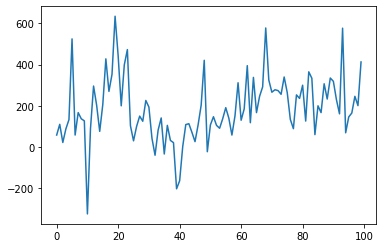

In [171]:
import matplotlib.pyplot as plt

plt.plot(_comments['_comments'])

In [0]:
_comments.to_csv('comments_and_submissions.csv')  